In [ ]:
import zipfile
import os
from google.colab import drive
import cv2

import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt

!pip install split-folders
import splitfolders

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.initializers import RandomNormal, Constant, HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras

In [ ]:
!rm -r data

rm: cannot remove 'data': No such file or directory


In [ ]:
#CARGAR LOS ARCHIVOS DESDE DRIVE

!mkdir data

drive.mount('/content/drive')

!cp /content/drive/MyDrive/PROYECTO_IA/train.zip ./data/


# Ruta al archivo ZIP
ruta_zip = '/content/data/train.zip'

# Directorio de destino para extraer las imágenes
directorio_destino = '/content/data/train'

# Extraer el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(directorio_destino)

# Listar los archivos extraídos
archivos_extraidos = os.listdir(directorio_destino)
print("Archivos extraídos:", archivos_extraidos)

Mounted at /content/drive
Archivos extraídos: ['Diego_Velazquez', 'Edouard_Manet', 'Edgar_Degas', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Henri_de_Toulouse-Lautrec', 'Albrecht_Durer', 'Salvador_Dali', 'Paul_Gauguin', 'Titian', 'Raphael', 'Leonardo_da_Vinci', 'Sandro_Botticelli', 'Marc_Chagall', 'Kazimir_Malevich', 'Georges_Seurat', 'Piet_Mondrian', 'El_Greco', 'Andy_Warhol', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Rene_Magritte', 'Gustav_Klimt', 'Henri_Rousseau', 'Camille_Pissarro', 'Jan_van_Eyck', 'Diego_Rivera', 'Gustave_Courbet', 'Francisco_Goya', 'Eugene_Delacroix', 'Michelangelo', 'Vasiliy_Kandinskiy', 'Amedeo_Modigliani', 'William_Turner', 'Paul_Klee', 'Claude_Monet', 'Rembrandt', 'Peter_Paul_Rubens', 'Andrei_Rublev', 'Paul_Cezanne', 'Pieter_Bruegel', 'Pierre-Auguste_Renoir', 'Alfred_Sisley', 'Frida_Kahlo', 'Edvard_Munch', 'Vincent_van_Gogh', 'Giotto_di_Bondone', 'Joan_Miro', 'Henri_Matisse', 'Caravaggio']


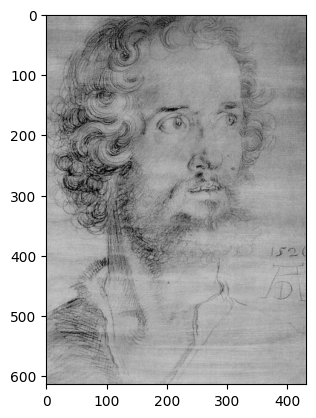

In [ ]:
img = cv2.imread(os.path.join('data', 'train', 'Albrecht_Durer', 'Albrecht_Durer_1.jpg'))
img.shape
plt.imshow(img)

In [ ]:
#PREPARAR LOS DATOS

# Ruta a la carpeta de datos de entrada
input_folder = "/content/data/train"

# Ruta a la carpeta de salida
output = "/content/data/training_sets"

# Dividir los datos en conjuntos de entrenamiento, prueba y validación
splitfolders.ratio(input_folder, output=output, seed=123, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 5823 files [00:01, 5254.36 files/s]


In [ ]:
datos_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/training_sets/train',
    batch_size=64,
    image_size=(512, 512)
)
datos_validacion = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/training_sets/val',
    batch_size=64,
    image_size=(512, 512)
)
datos_prueba = tf.keras.preprocessing.image_dataset_from_directory(
'/content/data/training_sets/test',
    batch_size=64,
    image_size=(512, 512)
)

Found 4636 files belonging to 50 classes.
Found 560 files belonging to 50 classes.
Found 627 files belonging to 50 classes.


In [ ]:
test_iterator = datos_entrenamiento.as_numpy_iterator()
batch = test_iterator.next()
batch[0].shape
batch[1]

array([ 0, 48, 10, 45, 33, 45, 36,  1,  1,  8, 27,  0,  2, 48, 18, 27, 11,
        9, 48, 38, 46, 37,  8, 33, 38, 44, 33, 10, 33, 36, 35, 39],
      dtype=int32)

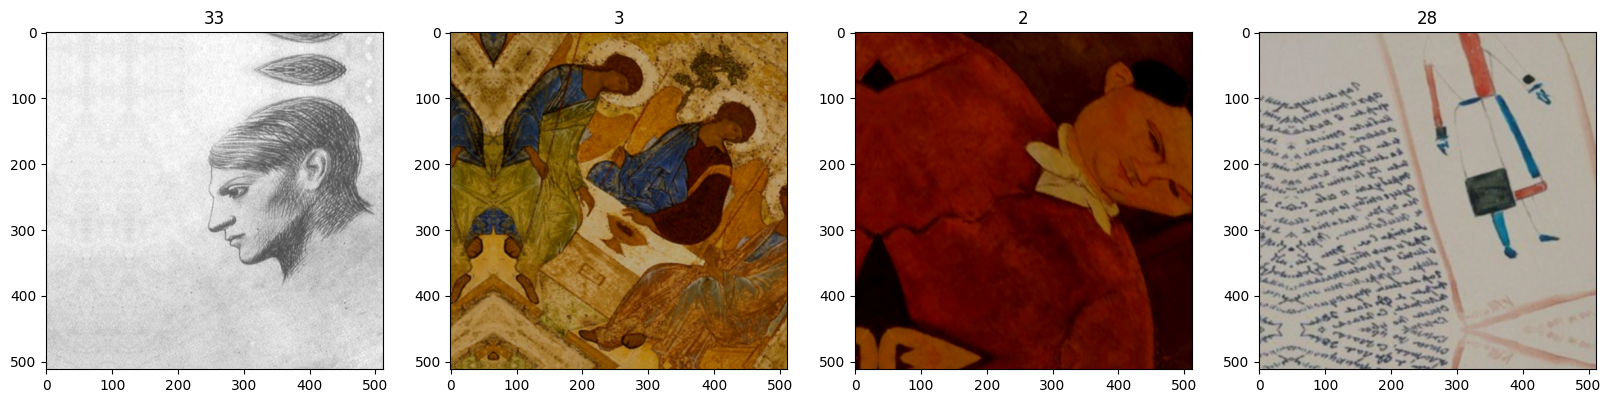

In [ ]:
for images, labels in datos_entrenamiento.take(1):
    fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
    for idx, img in enumerate(images[:4]):
        ax[idx].imshow(img.numpy())
        ax[idx].title.set_text(labels[idx].numpy())
    plt.show()

In [ ]:
#Normalizacion

datos_entrenamiento = datos_entrenamiento.map(lambda x,y: (x/255, y))
datos_validacion = datos_validacion.map(lambda x,y: (x/255, y))
datos_prueba = datos_prueba.map(lambda x,y: (x/255, y))

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15, seed= 123),
    tf.keras.layers.RandomZoom(0.15, seed= 123),
    tf.keras.layers.RandomContrast(0.15, seed= 123),
    tf.keras.layers.RandomBrightness(0.15, seed= 123)
])


def augment(ds):

  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
      num_parallel_calls=tf.data.AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
datos_entrenamiento = augment(datos_entrenamiento)

In [ ]:
test_iterator = datos_entrenamiento.as_numpy_iterator()
print(test_iterator.next()[0].max(), '/ ',
test_iterator.next()[0].min())

255.0 /  0.0


In [ ]:
model = Sequential([
    # Primera capa convolucional: filtro grande para características amplias
    Conv2D(32, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same',
           kernel_initializer=HeNormal(), input_shape=(512, 512, 3),
           kernel_regularizer=l2(0.001)),  # Regularización L2
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    #Dropout(0.1),

    # Segunda capa convolucional: filtro mediano para detalles intermedios
    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=HeNormal(),
           kernel_regularizer=l2(0.001)),  # Regularización L2
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
      #Dropout(0.2),

    # Tercera capa convolucional: filtro pequeño para detalles finos
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=HeNormal(),
           kernel_regularizer=l2(0.001)),  # Regularización L2
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    #Dropout(0.3),

    # Cuarta capa convolucional: otro filtro pequeño para refinar detalles
    Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=HeNormal(),
           kernel_regularizer=l2(0.001)),  # Regularización L2
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.3),

    # Aplanar las activaciones 3D en un vector 1D y capa densa
    Flatten(),
    Dense(512, activation='relu', kernel_initializer=HeNormal(),
          kernel_regularizer=l2(0.1)),  # Regularización L2 en la capa densa
    BatchNormalization(),
    Dropout(0.5),

    # Capa de salida
    Dense(50, activation='softmax')
])

# Compilación del modelo con una tasa de aprendizaje ligeramente más alta
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Imprimir la arquitectura del modelo para confirmar las adiciones
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 256, 256, 32)      4736      
                                                                 
 batch_normalization_34 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_35 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                      

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=0.00001, verbose=1)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Entrenamiento del modelo
history = model.fit(
    datos_entrenamiento,
    epochs=200,
    validation_data=datos_validacion,
    callbacks=[reduce_lr, early_stopping_callback]
)

Epoch 1/200
73/73 [==============================] - 39s 397ms/step - loss: 32.8509 - accuracy: 0.1393 - val_loss: 13.1574 - val_accuracy: 0.0725 - lr: 0.0010
Epoch 2/200
73/73 [==============================] - 37s 438ms/step - loss: 12.5677 - accuracy: 0.1519 - val_loss: 12.6039 - val_accuracy: 0.1036 - lr: 0.0010
Epoch 3/200
73/73 [==============================] - 37s 433ms/step - loss: 11.8159 - accuracy: 0.1663 - val_loss: 11.8927 - val_accuracy: 0.1247 - lr: 0.0010
Epoch 4/200
73/73 [==============================] - 37s 434ms/step - loss: 11.5034 - accuracy: 0.1859 - val_loss: 11.1142 - val_accuracy: 0.1820 - lr: 0.0010
Epoch 5/200
73/73 [==============================] - 37s 432ms/step - loss: 10.9530 - accuracy: 0.1982 - val_loss: 10.9120 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 6/200
73/73 [==============================] - 37s 436ms/step - loss: 10.4511 - accuracy: 0.1937 - val_loss: 10.0617 - val_accuracy: 0.2258 - lr: 0.0010
Epoch 7/200
73/73 [===========================

In [ ]:
model.evaluate(datos_prueba)

10/10 [==============================] - 1s 92ms/step - loss: 2.5467 - accuracy: 0.5805


[2.5466506481170654, 0.580542266368866]

In [ ]:
model.save('/content/drive/My Drive/PROYECTO_IA/modeloA', save_format='tf')


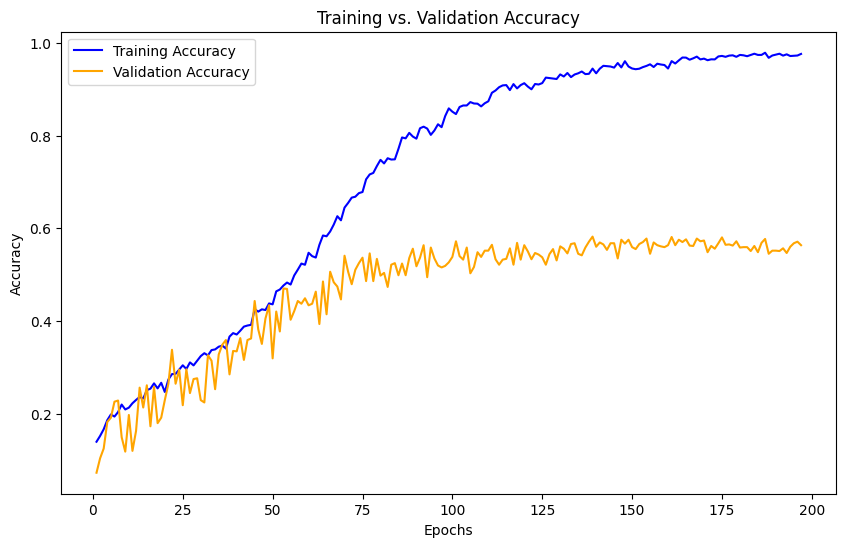

In [ ]:
# Accediendo a los datos de precisión de entrenamiento y validación del historial de entrenamiento
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Creando la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, '-', label='Training Accuracy', color='blue')  # Línea azul para el entrenamiento
plt.plot(epochs, val_acc, '-', label='Validation Accuracy', color='orange')  # Línea naranja para la validación
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
modelB = Sequential([
    # Primera capa convolucional: filtro grande para características amplias
    Conv2D(32, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same',
           kernel_initializer=HeNormal(), input_shape=(512, 512, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    # Segunda capa convolucional: filtro mediano para detalles intermedios
    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=HeNormal()),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    # Tercera capa convolucional: filtro pequeño para detalles finos
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=HeNormal()),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),


    # Cuarta capa convolucional: otro filtro pequeño para refinar detalles
    Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=HeNormal()),  # Regularización L2
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Aplanar las activaciones 3D en un vector 1D y capa densa
    Flatten(),
    Dense(512, activation='relu', kernel_initializer=HeNormal()),  # Regularización L2 en la capa densa

    # Capa de salida
    Dense(50, activation='softmax')
])

# Compilación del modelo con una tasa de aprendizaje ligeramente más alta
modelB.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Imprimir la arquitectura del modelo para confirmar las adiciones
modelB.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 256, 256, 32)      4736      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 32, 32, 128)     

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=0.00001, verbose=1)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Entrenamiento del modelo
history = modelB.fit(
    datos_entrenamiento,
    epochs=200,
    validation_data=datos_validacion,
    callbacks=[reduce_lr, early_stopping_callback]
)

Epoch 1/200
73/73 [==============================] - 41s 399ms/step - loss: 4.7486 - accuracy: 0.1150 - val_loss: 3.3280 - val_accuracy: 0.1643 - lr: 0.0010
Epoch 2/200
73/73 [==============================] - 37s 440ms/step - loss: 3.2533 - accuracy: 0.1818 - val_loss: 3.1414 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 3/200
73/73 [==============================] - 37s 440ms/step - loss: 3.0472 - accuracy: 0.2123 - val_loss: 2.8858 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 4/200
73/73 [==============================] - 37s 442ms/step - loss: 2.9120 - accuracy: 0.2506 - val_loss: 2.7674 - val_accuracy: 0.2932 - lr: 0.0010
Epoch 5/200
73/73 [==============================] - 37s 441ms/step - loss: 2.7611 - accuracy: 0.2711 - val_loss: 2.7108 - val_accuracy: 0.2890 - lr: 0.0010
Epoch 6/200
73/73 [==============================] - 37s 435ms/step - loss: 2.6411 - accuracy: 0.2923 - val_loss: 2.6426 - val_accuracy: 0.3168 - lr: 0.0010
Epoch 7/200
73/73 [==============================] - 37s 4

In [ ]:
modelB.evaluate(datos_prueba)

10/10 [==============================] - 1s 85ms/step - loss: 2.3239 - accuracy: 0.3892


[2.3238518238067627, 0.38915470242500305]

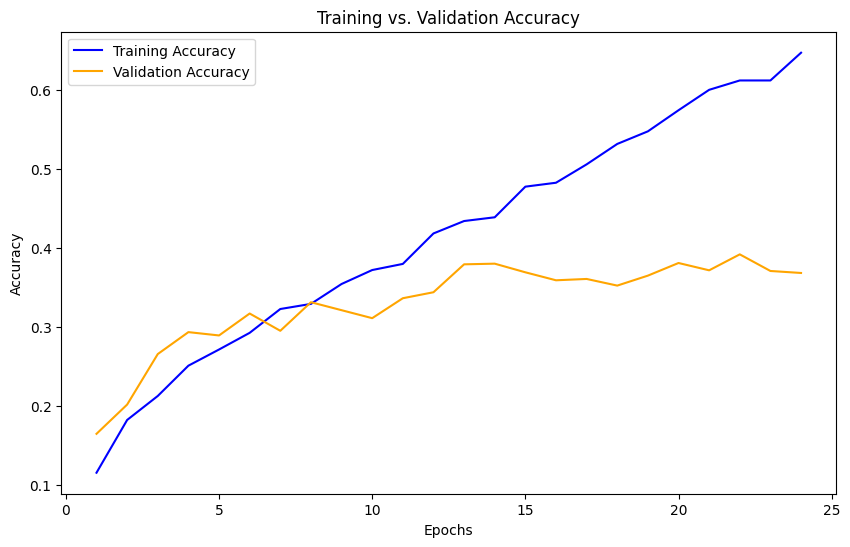

In [ ]:
# Accediendo a los datos de precisión de entrenamiento y validación del historial de entrenamiento
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Creando la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, '-', label='Training Accuracy', color='blue')  # Línea azul para el entrenamiento
plt.plot(epochs, val_acc, '-', label='Validation Accuracy', color='orange')  # Línea naranja para la validación
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
modelB.save('/content/drive/My Drive/PROYECTO_IA/modeloB', save_format='tf')

In [ ]:

modelC = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), input_shape=(512,512,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    keras.layers.Conv2D(32, (2,2), activation='relu', strides=(2,2), padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

    keras.layers.Conv2D(16, (2,2), activation='relu', strides=(2,2), padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(50, activation='softmax')
])

modelC.compile(
    optimizer=SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelC.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        2064      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)       

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=0.00001, verbose=1)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# Entrenamiento del modelo
historyC = modelC.fit(
    datos_entrenamiento,
    epochs=200,
    validation_data=datos_validacion,
    callbacks=[reduce_lr, early_stopping_callback]
)

Epoch 1/200
73/73 [==============================] - 40s 351ms/step - loss: 3.6750 - accuracy: 0.0943 - val_loss: 3.6512 - val_accuracy: 0.0875 - lr: 0.1000
Epoch 2/200
73/73 [==============================] - 35s 407ms/step - loss: 3.5761 - accuracy: 0.1074 - val_loss: 3.5599 - val_accuracy: 0.0893 - lr: 0.1000
Epoch 3/200
73/73 [==============================] - 35s 402ms/step - loss: 3.4778 - accuracy: 0.1270 - val_loss: 3.3418 - val_accuracy: 0.1464 - lr: 0.1000
Epoch 4/200
73/73 [==============================] - 34s 406ms/step - loss: 3.3964 - accuracy: 0.1376 - val_loss: 3.2907 - val_accuracy: 0.1839 - lr: 0.1000
Epoch 5/200
73/73 [==============================] - 34s 405ms/step - loss: 3.3173 - accuracy: 0.1544 - val_loss: 3.3079 - val_accuracy: 0.1250 - lr: 0.1000
Epoch 6/200
73/73 [==============================] - 34s 402ms/step - loss: 3.2734 - accuracy: 0.1555 - val_loss: 3.3629 - val_accuracy: 0.1393 - lr: 0.1000
Epoch 7/200
73/73 [==============================] - 35s 4

In [ ]:
modelC.evaluate(datos_prueba)

10/10 [==============================] - 2s 135ms/step - loss: 2.3333 - accuracy: 0.4019


[2.333307981491089, 0.4019138813018799]

In [ ]:
modelC.save('/content/drive/My Drive/PROYECTO_IA/modeloC', save_format='tf')

In [ ]:
modelC.save('/content/drive/My Drive/PROYECTO_IA/modeloC.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


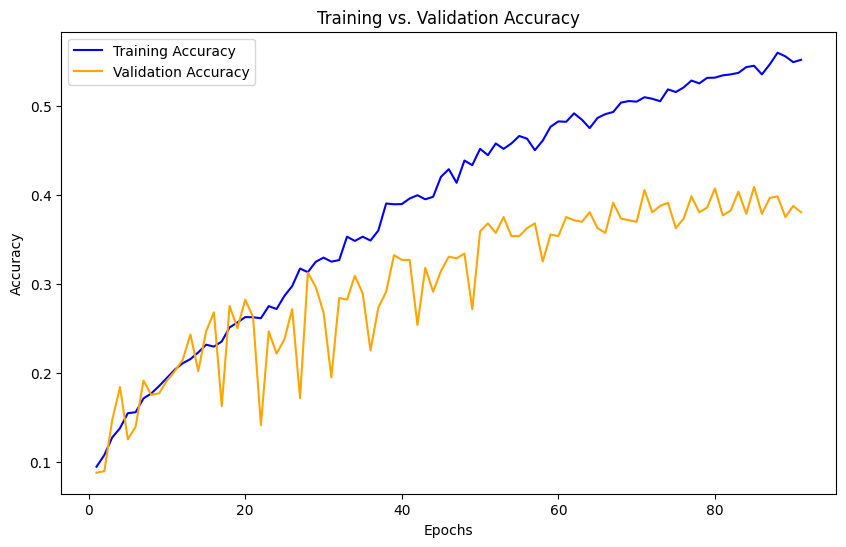

In [ ]:
# Accediendo a los datos de precisión de entrenamiento y validación del historial de entrenamiento
train_acc = historyC.history['accuracy']
val_acc = historyC.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Creando la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, '-', label='Training Accuracy', color='blue')  # Línea azul para el entrenamiento
plt.plot(epochs, val_acc, '-', label='Validation Accuracy', color='orange')  # Línea naranja para la validación
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
